# SPADE: image synthesis from semantic layouts

## [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ml4a/ml4a-guides/blob/ml4a.net/examples/models/SPADE.ipynb)

Generate photorealistic images from semantic label maps. See the [original code](https://github.com/NVlabs/SPADE) and [paper](https://arxiv.org/abs/1903.07291).

## Set up ml4a and enable GPU

If you don't already have ml4a installed, or you are opening this in Colab, first enable GPU (`Runtime` > `Change runtime type`), then run the following cell to install ml4a and its dependencies.

In [ ]:
%tensorflow_version 1.x
!pip3 install --quiet ml4a

# List available pre-trained models

In [1]:
from ml4a import image
from ml4a.models import spade

print(spade.get_pretrained_models())

dict_keys(['cityscapes', 'ade20k', 'coco', 'landscapes'])


# Load landscapes model

Print the class table with `spade.classes`.

In [2]:
spade.load_model('landscapes')
print(spade.classes)

Network [SPADEGenerator] was created. Total number of parameters: 97.4 million. To see the architecture, do print(network).
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'street sign', 12: 'stop sign', 13: 'parking meter', 14: 'bench', 15: 'bird', 16: 'cat', 17: 'dog', 18: 'horse', 19: 'sheep', 20: 'cow', 21: 'elephant', 22: 'bear', 23: 'zebra', 24: 'giraffe', 25: 'hat', 26: 'backpack', 27: 'umbrella', 28: 'shoe', 29: 'eye glasses', 30: 'handbag', 31: 'tie', 32: 'suitcase', 33: 'frisbee', 34: 'skis', 35: 'snowboard', 36: 'sports ball', 37: 'kite', 38: 'baseball bat', 39: 'baseball glove', 40: 'skateboard', 41: 'surfboard', 42: 'tennis racket', 43: 'bottle', 44: 'plate', 45: 'wine glass', 46: 'cup', 47: 'fork', 48: 'knife', 49: 'spoon', 50: 'bowl', 51: 'banana', 52: 'apple', 53: 'sandwich', 54: 'orange', 55: 'broccoli', 56: 'carrot', 57: 'hot dog', 58: 'pizza', 59: 'donut', 6

Pass the labels from `semantic_segmentation` to `SPADE`. Note the class labels are not identical, so some conversion is needed.

Loading weights for net_encoder
Loading weights for net_decoder


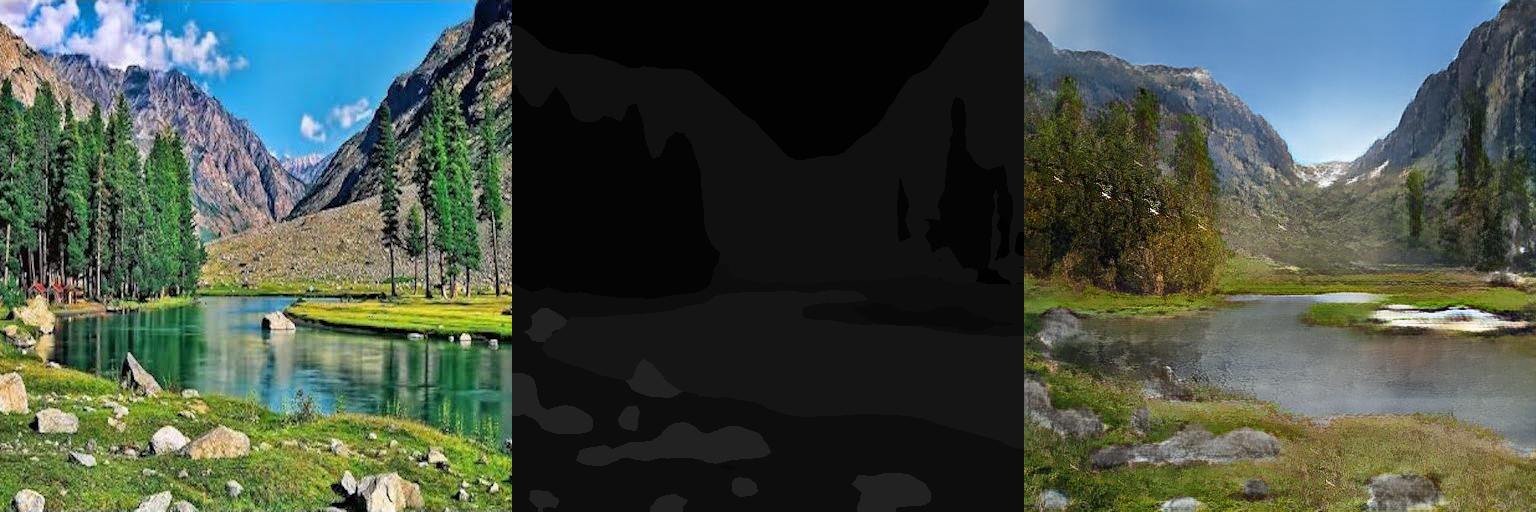

In [3]:
from ml4a.models import semantic_segmentation

img = image.load_image('https://github.com/abraham-ai/eden/raw/master/images/mountains.jpg', (512, 512))
labels = semantic_segmentation.run(img)

# convert labels between datasets (coco or landscapes)
labels2 = labels.copy()
labels2[labels == semantic_segmentation.get_class_index('mountain')] = spade.get_class_index('mountain')
labels2[labels == semantic_segmentation.get_class_index('earth')] = spade.get_class_index('grass')
labels2[labels == semantic_segmentation.get_class_index('water')] = spade.get_class_index('river')
labels2[labels == semantic_segmentation.get_class_index('tree')] = spade.get_class_index('tree')
labels2[labels == semantic_segmentation.get_class_index('sky')] = spade.get_class_index('sky-other')

# convert labels between datasets (ade20k)
# labels2[labels == semantic_segmentation.get_class_index('mountain')] = spade.get_class_index('building')
# labels2[labels == semantic_segmentation.get_class_index('earth')] = spade.get_class_index('sidewalk')
# labels2[labels == semantic_segmentation.get_class_index('water')] = spade.get_class_index('water')
# labels2[labels == semantic_segmentation.get_class_index('tree')] = spade.get_class_index('tree')
# labels2[labels == semantic_segmentation.get_class_index('sky')] = spade.get_class_index('sky')

# convert labels between datasets (cityscapes)
# labels2[labels == semantic_segmentation.get_class_index('mountain')] = spade.get_class_index('building')
# labels2[labels == semantic_segmentation.get_class_index('earth')] = spade.get_class_index('sidewalk')
# labels2[labels == semantic_segmentation.get_class_index('water')] = spade.get_class_index('road')
# labels2[labels == semantic_segmentation.get_class_index('tree')] = spade.get_class_index('vegetation')
# labels2[labels == semantic_segmentation.get_class_index('sky')] = spade.get_class_index('sky')


img2 = spade.run(labels2)

all_images = image.concatenate_images([img, labels, img2])
image.display(all_images)

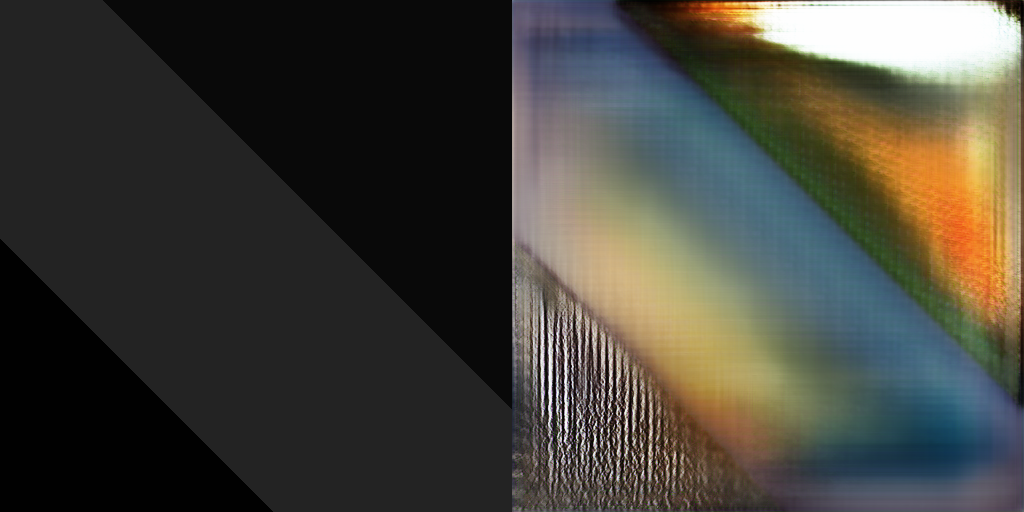

In [6]:
from ml4a.canvas import mask

size = (512, 512)
        

mask_config = {
    'type': 'rects',
    'size': size, 
    'num_channels': 3, 
    'p1': (1.0, 0.0), 
    'p2': (0.0, 1.0), 
    'width': 3.0, 
    'period': 20,
    'blend': 0.2, 
    'reverse': True
}

import numpy as np

m = mask.get_mask(mask_config)

        
labels = np.zeros(size)
labels[m[:, :, 0]>0] = spade.get_class_index('river')
labels[m[:, :, 1]>0] = spade.get_class_index('tree')
labels[m[:, :, 2]>0] = spade.get_class_index('sky-other')

import random
idx = [int(len(spade.classes)*random.random()*0.2) for i in range(3)]
labels[m[:, :, 0]>0] = idx[0]
labels[m[:, :, 1]>0] = idx[1]
labels[m[:, :, 2]>0] = idx[2]


# m[]
# labels[m[]] = spade.get_class_index('grass')
# labels[labels == semantic_segmentation.get_class_index('water')] = spade.get_class_index('river')
# labels[labels == semantic_segmentation.get_class_index('tree')] = spade.get_class_index('tree')
# labels[labels == semantic_segmentation.get_class_index('sky')] = spade.get_class_index('sky-other')

img2 = spade.run(labels)

all_images = image.concatenate_images([labels, img2])
image.display(all_images)


In [11]:
from random import random
from tqdm import tqdm
from noise import pnoise2, snoise2

w, h = size
num_classes = 5

idx = [int(len(spade.classes)*random()*0.2) for i in range(num_classes)]
thresholds = [1.0]+list(sorted([random() for i in range(num_classes-1)], reverse=True))

tx, ty = 0.004*random(), 0.004*random()
ox, oy = 500*random(), 599*random()
mx, my = 0.004*random(), 0.004*random()


frames = []
for f in tqdm(range(200)):
    
    x = [[pnoise2(ox+tx*f+mx*i, oy+ty*f+my*j) for j in range(h)] for i in range(w)]
    x = np.array(x)
    x = (x-np.min(x)) / (np.max(x)-np.min(x))

    labels = np.zeros(x.shape)
    for t, thresh in enumerate(thresholds):
        labels[x<thresh] = idx[t]

    img2 = spade.run(labels)
    #all_images = image.concatenate_images([(255/np.max(labels))*labels, img2])
    #image.display(all_images)
    frames.append(img2)


100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


In [12]:
image.display(frames, animate=True)